# Create Helper Functions

In [30]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    q = '''
    SELECT
    name,
    type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Select Albums to Purchase

In [31]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT invoice_line.* FROM invoice_line
    INNER JOIN invoice on invoice_line.invoice_id = invoice.invoice_id
    INNER JOIN customer on invoice.customer_id = customer.customer_id
    WHERE customer.country = "USA"
   )
   
SELECT
    genre.name genre,
    COUNT(usa_tracks_sold.invoice_line_id) tracks_sold,
    CAST(COUNT(usa_tracks_sold.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold
INNER JOIN track on track.track_id = usa_tracks_sold.track_id
INNER JOIN genre on genre.genre_id = track.genre_id
GROUP BY genre
ORDER BY 2 DESC
LIMIT 10;
'''
run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


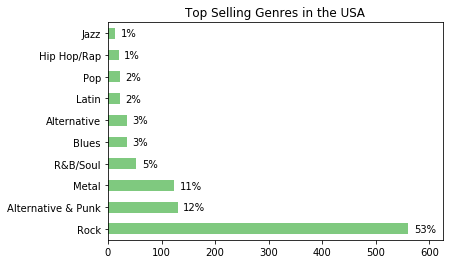

In [32]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

# Top 10 Artists in the U.S.

In [33]:
top_US_artists = '''
WITH usa_tracks_sold AS
   (
    SELECT invoice_line.* FROM invoice_line
    INNER JOIN invoice on invoice_line.invoice_id = invoice.invoice_id
    INNER JOIN customer on invoice.customer_id = customer.customer_id
    WHERE customer.country = "USA"
   )
   
SELECT
    artist.name artist,
    COUNT(usa_tracks_sold.invoice_line_id) tracks_sold,
    CAST(COUNT(usa_tracks_sold.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold
INNER JOIN track on track.track_id = usa_tracks_sold.track_id
INNER JOIN album on album.album_id = track.album_id
INNER JOIN artist on artist.artist_id = album.artist_id
GROUP BY artist
ORDER BY tracks_sold DESC
LIMIT 10;
'''
run_query(top_US_artists)

,artist,tracks_sold,percentage_sold
0,Van Halen,43,0.040913
1,R.E.M.,38,0.036156
2,The Rolling Stones,37,0.035205
3,Nirvana,35,0.033302
4,Eric Clapton,34,0.032350
5,Foo Fighters,34,0.032350
6,Green Day,32,0.030447
7,Guns N' Roses,32,0.030447
8,Pearl Jam,31,0.029496
9,Amy Winehouse,30,0.028544


# Top 10 Artists Worldwide

In [34]:
top_world_artists = '''
WITH tracks_sold_ww AS
   (
    SELECT invoice_line.* FROM invoice_line
    INNER JOIN invoice on invoice_line.invoice_id = invoice.invoice_id
    INNER JOIN customer on invoice.customer_id = customer.customer_id
    )
   
SELECT
    artist.name artist,
    COUNT(tracks_sold_ww.invoice_line_id) tracks_sold,
    CAST(COUNT(tracks_sold_ww.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) FROM tracks_sold_ww
    ) percentage_sold
FROM tracks_sold_ww
INNER JOIN track on track.track_id = tracks_sold_ww.track_id
INNER JOIN album on album.album_id = track.album_id
INNER JOIN artist on artist.artist_id = album.artist_id
GROUP BY artist
ORDER BY tracks_sold DESC
LIMIT 10;
'''
run_query(top_world_artists)

,artist,tracks_sold,percentage_sold
0,Queen,192,0.040362
1,Jimi Hendrix,187,0.039310
2,Nirvana,130,0.027328
3,Red Hot Chili Peppers,130,0.027328
4,Pearl Jam,129,0.027118
5,AC/DC,124,0.026067
6,Guns N' Roses,124,0.026067
7,Foo Fighters,121,0.025436
8,The Rolling Stones,117,0.024595
9,Metallica,106,0.022283


### Findings & Recommendations
#### •With the advent of mp3s on demand, no one really buys entire albums anymore. However from the Top Selling Genre bar plot, Rock comprises the bulk of sales in the U.S. It is safe to recommend new album purchases from this genre.
#### •From the Top 10 U.S. and World Artists, the top artists have not released a new album in years. There is also no release date information for tracks or albums in this database which would have been useful to cross-reference in order to select do more detailed market research.
#### •Recommend albums from:
1. Red Tone  
2. Slim Jim Bites  
3. Meteor and the Girls

# Employee Sales Performance

In [35]:
e_s_p = '''
WITH support_rep_sales AS
    (
     SELECT
         invoice.customer_id,
         customer.support_rep_id,
         SUM(invoice.total) total
     FROM invoice
     INNER JOIN customer ON customer.customer_id = invoice.customer_id
     GROUP BY 1,2
    )

SELECT
    employee.first_name || " " || employee.last_name employee,
    employee.hire_date,
    SUM(support_rep_sales.total) total_sales
FROM support_rep_sales
INNER JOIN employee ON employee.employee_id = support_rep_sales.support_rep_id
GROUP BY 1;
'''

run_query(e_s_p)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


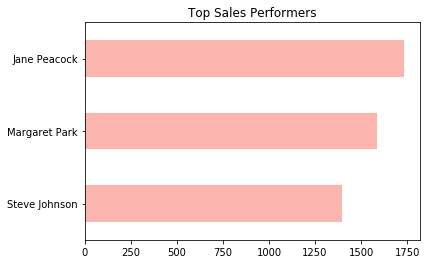

In [36]:
employee_sales = run_query(e_s_p)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Top Sales Performers',
    colormap=plt.cm.Pastel1
)
plt.ylabel('')
plt.show()

### Findings
#### •The difference between the top three performers is accounted by their hire date. Jane was hired the earliest of the three. 

# Analyze Sales by Country

In [37]:
sales_by_country = '''
WITH sort_country AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT COUNT(*)
                 FROM customer
                 WHERE country = customer.country
                 ) = 1 THEN "Other"
           ELSE customer.country
    END AS country,
    customer.customer_id,
    invoice_line.*
    FROM invoice_line
    INNER JOIN invoice ON invoice.invoice_id = invoice_line.invoice_id
    INNER JOIN customer ON customer.customer_id = invoice.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price)/COUNT(distinct customer_id) customer_lifetime_value,
        SUM(unit_price)/COUNT(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM sort_country
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Ireland,1,114.84,8.833846,114.840000


# Visualize Sales by Country

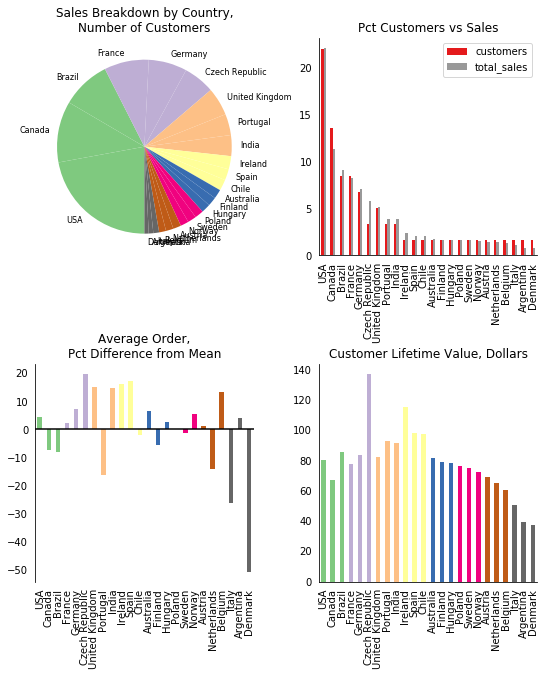

In [38]:
sales_worldwide = run_query(sales_by_country)
sales_worldwide.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, sales_worldwide.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = sales_worldwide["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = sales_worldwide[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = sales_worldwide["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = sales_worldwide["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

### Findings & Recommendations
#### •From this dataset Czech Republic, UK & India seem to be emerging markets.
#### •Overall however, the customer sample size is too small to make any prudent recommendations.
#### •More data on worldwide sales needs to be collected before any overseas campaigns are launched.

# Albums vs Individual Tracks

In [39]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


### Findings & Recommendations
#### •Album sales comprise only 18.56% of purchases which confirms my previous claim that track sales outperform album sales.
#### •Recommend only purchasing popular individual tracks from particular albums.